# Solemne 1 
## Mineria de datos 
### Trabajo con bases de datos con gcloud y  bigquerys 



#### Para empezar: 

* Para comenzar estableceremos una coneccion como cliente con la base de datos de  bigquery, en la cual tomaremos una base de datos llamada "covid19_ecd_eu", alojada en "bigquery-public-data" y trataremos de responder unas preguntas basicas del comportamiento del covid19 en el mundo. 

* El dataframe se trabajará mediante un combinacion entre consultas SQL y la libreria pandas, para poder realizar un analisis mas exhaustivo de los datos. 

Primeramente se obtiene la base de datos, el cual es un procedimiento estandar. 


In [1]:
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt
from google.cloud import bigquery

import numpy as np 


In [2]:


# Inicializa el cliente de BigQuery
client = bigquery.Client()

# Referencia al conjunto de datos
dataset_ref = client.dataset("covid19_ecdc_eu", project="bigquery-public-data")
dataset = client.get_dataset(dataset_ref)

# Referencia a la tabla que deseas consultar
table_ref = dataset_ref.table("covid_19_geographic_distribution_worldwide")
table = client.get_table(table_ref)

# Consulta los datos y conviértelos en un DataFrame de Pandas
df = client.list_rows(table, max_results=5000).to_dataframe()

# Obtiene el número de filas y columnas del DataFrame
num_filas, num_columnas = df.shape
print("El DataFrame tiene {} filas y {} columnas.".format(num_filas, num_columnas))

df


El DataFrame tiene 5000 filas y 12 columnas.


,date,day,month,year,daily_confirmed_cases,daily_deaths,confirmed_cases,deaths,countries_and_territories,geo_id,country_territory_code,pop_data_2019
0,2019-12-31,31,12,2019,0,0,0,0,Cases_on_an_international_conveyance_Japan,JPG11668,None,<NA>
1,2019-12-31,31,12,2019,0,0,0,0,Afghanistan,AF,AFG,38041757
2,2019-12-31,31,12,2019,0,0,0,0,United_Arab_Emirates,AE,ARE,9770526
3,2019-12-31,31,12,2019,0,0,0,0,Armenia,AM,ARM,2957728
4,2019-12-31,31,12,2019,0,0,0,0,Australia,AU,AUS,25203200
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2020-04-03,3,4,2020,0,0,74,5,Niger,NE,NER,23310719
4996,2020-04-04,4,4,2020,24,0,98,5,Niger,NE,NER,23310719
4997,2020-04-05,5,4,2020,22,0,120,5,Niger,NE,NER,23310719
4998,2020-04-07,7,4,2020,69,0,253,10,Niger,NE,NER,23310719


In [3]:
# Convierte la columna de fechas a tipo datetime si no lo está
df['date'] = pd.to_datetime(df['date'])

# Encuentra la última fecha en el dataset
ultima_fecha = df['date'].max()

print("La última fecha en el dataset es:", ultima_fecha)


La última fecha en el dataset es: 2020-12-14 00:00:00


Ahora que tenemos el DataFrame, podemos hacer unas consultas SQL. En este caso mis consultas estarán basadas en ña pregunta: Cual es el país con más contagios por día?. 

In [4]:
# Para hacer esta pregunta creamos la siguiente consulta 

query_paises = """ 
SELECT date,countries_and_territories , confirmed_cases
FROM bigquery-public-data.covid19_ecdc_eu.covid_19_geographic_distribution_worldwide
"""


query_job = client.query(query_paises)



Ahora que ya subimos la consulta. Podemos convertirla en un DataFrame y trabajarlo con Pandas.  

In [5]:
df_paises = query_job.to_dataframe()
df_paises


,date,countries_and_territories,confirmed_cases
0,2019-12-31,Cases_on_an_international_conveyance_Japan,0
1,2019-12-31,Afghanistan,0
2,2019-12-31,United_Arab_Emirates,0
3,2019-12-31,Armenia,0
4,2019-12-31,Australia,0
...,...,...,...
61895,2020-02-17,Taiwan,20
61896,2020-03-21,Taiwan,135
61897,2020-04-12,Taiwan,385
61898,2020-05-12,Taiwan,440


Teniendo la data, haremos un grafico tal que muestre la densidad demografica de los casos confirmados. 

* Para ello primero buscamos los caso maximos de covid (hasta la fecha que nos da el DataFrame), como 'confirmed_cases' es un contandor que solo va en aumento, solo basta con pedirle la funcion Max() , el cual simplemente nos retornará el maximo de cada row.  


In [6]:
casos_totales_por_pais = df_paises.groupby('countries_and_territories')['confirmed_cases'].max().reset_index()

print(casos_totales_por_pais)
type(casos_totales_por_pais) #Compruebo si es un dataframe para seguir trabajando. 

    countries_and_territories  confirmed_cases
0                 Afghanistan            49273
1                     Albania            48530
2                     Algeria            92102
3                     Andorra             7338
4                      Angola            16188
..                        ...              ...
209         Wallis_and_Futuna                3
210            Western_Sahara              766
211                     Yemen             2083
212                    Zambia            18274
213                  Zimbabwe            11246

[214 rows x 2 columns]


pandas.core.frame.DataFrame

C:\Users\Benja\AppData\Local\Temp\ipykernel_8368\156473114.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


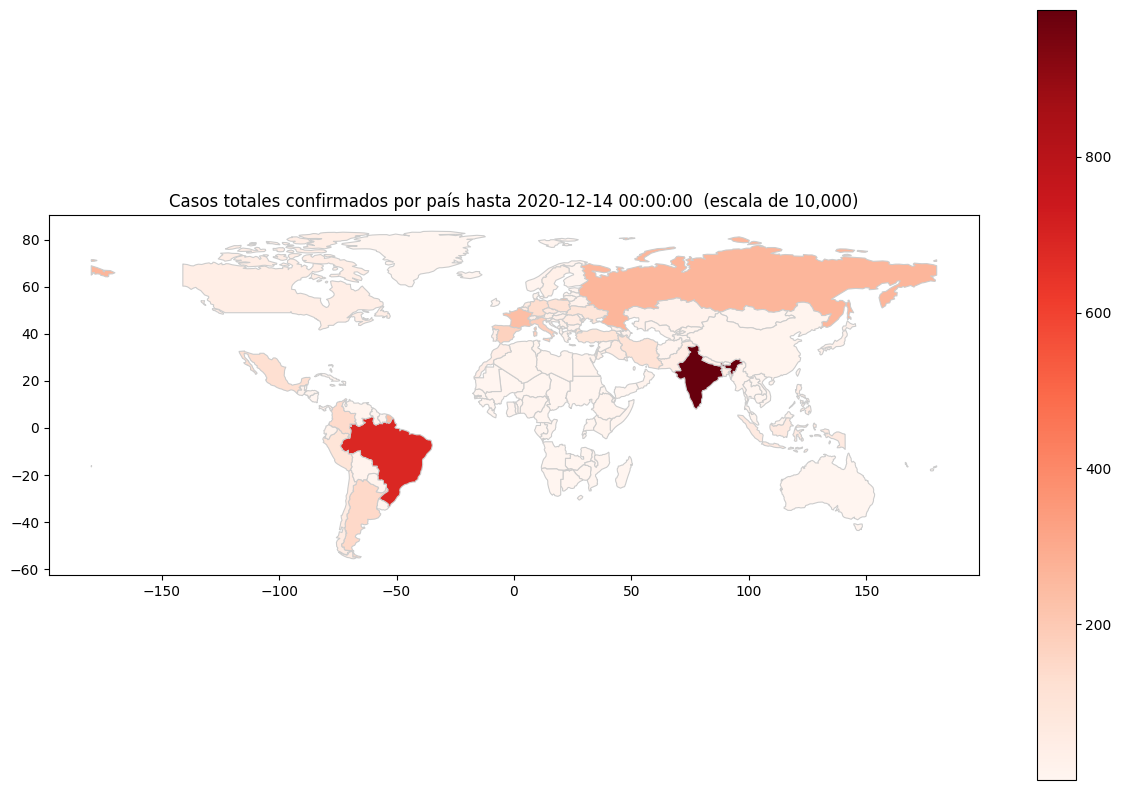

In [7]:
# Cargo el conjunto de datos de países de geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Calculo los casos totales ajustados por país (dividir por 10,000)
casos_totales_por_pais['confirmed_cases_scaled'] = casos_totales_por_pais['confirmed_cases'] /10000

# Fusiono los datos de casos totales ajustados con el conjunto de datos de países basado en el nombre del país
world = world.merge(casos_totales_por_pais, how='left', left_on='name', right_on='countries_and_territories')



fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(column='confirmed_cases_scaled', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Casos totales confirmados por país hasta 2020-12-14 00:00:00  (escala de 10,000)')
plt.show()

In [8]:
#Podemos saber cuales son los paises con mas contagios y los paises con menos contagiados 
casos_totales_por_pais_sorted = casos_totales_por_pais.sort_values(by='confirmed_cases', ascending=False)
# Los cuatro países más contagiados
paises_mas_contagiados = casos_totales_por_pais_sorted.head(4)

# Los cuatro países menos contagiados
paises_menos_contagiados = casos_totales_por_pais_sorted.tail(4)

print("Los cuatro países más contagiados son:")
print(paises_mas_contagiados)
print(type(paises_mas_contagiados))

print("\nLos cuatro países menos contagiados son:")
print(paises_menos_contagiados)
print(type(paises_menos_contagiados))


Los cuatro países más contagiados son:
    countries_and_territories  confirmed_cases  confirmed_cases_scaled
203  United_States_of_America         16256754               1625.6754
92                      India          9884100                  988.41
27                     Brazil          6901952                690.1952
160                    Russia          2653928                265.3928
<class 'pandas.core.frame.DataFrame'>

Los cuatro países menos contagiados son:
    countries_and_territories  confirmed_cases  confirmed_cases_scaled
5                    Anguilla               10                   0.001
124          Marshall_Islands                4                  0.0004
209         Wallis_and_Futuna                3                  0.0003
206                   Vanuatu                1                  0.0001
<class 'pandas.core.frame.DataFrame'>


### Parte 2 
Correlacion entre dos variables: 



In [9]:
client = bigquery.Client()

# Referencia al conjunto de datos
dataset_ref1 = client.dataset("census_bureau_international", project="bigquery-public-data")

# Referencia a la tabla
table_ref1 = dataset_ref1.table("midyear_population")

# Obtiene la tabla
table1 = client.get_table(table_ref1)

# Consulta los datos y conviértelos en un DataFrame de Pandas
df1 = client.list_rows(table1, max_results=50000).to_dataframe()

# Obtiene el número de filas y columnas del DataFrame
num_filas, num_columnas = df1.shape
print("El DataFrame tiene {} filas y {} columnas.".format(num_filas, num_columnas))

df1.rename(columns={'country_code': 'country_territory_code'}, inplace=True)
df1

El DataFrame tiene 23028 filas y 4 columnas.


,country_territory_code,country_name,year,midyear_population
0,AA,Aruba,1950,49712
1,AA,Aruba,1951,51335
2,AA,Aruba,1952,51955
3,AA,Aruba,1953,52585
4,AA,Aruba,1954,53220
...,...,...,...,...
23023,ZI,Zimbabwe,2046,23761751
23024,ZI,Zimbabwe,2047,24200361
23025,ZI,Zimbabwe,2048,24645093
23026,ZI,Zimbabwe,2049,25095949


In [10]:
query_paises = """ 
SELECT date,geo_id , confirmed_cases
FROM bigquery-public-data.covid19_ecdc_eu.covid_19_geographic_distribution_worldwide
"""


query_job = client.query(query_paises)
a = query_job.to_dataframe()
a
casos_totales_id = a.groupby('geo_id')['confirmed_cases'].max().reset_index()
casos_totales_id

,geo_id,confirmed_cases
0,AD,7338
1,AE,184949
2,AF,49273
3,AG,148
4,AI,10
...,...,...
209,XK,46580
210,YE,2083
211,ZA,860964
212,ZM,18274


In [11]:
query = """
    SELECT
        country_code,
        
        midyear_population
    FROM
        `bigquery-public-data.census_bureau_international.midyear_population`
    WHERE
        year = 2020
"""

# Ejecutar la consulta
query_job = client.query(query)

# Convertir los resultados en un DataFrame de Pandas
df1 = query_job.to_dataframe()

# Mostrar el DataFrame

df1.rename(columns={'country_code': 'geo_id'}, inplace=True)
df1

,geo_id,midyear_population
0,AA,119428
1,AC,98179
2,AE,9992083
3,AF,36643815
4,AG,42972878
...,...,...
223,WS,203774
224,WZ,1104479
225,YM,29884405
226,ZA,17426623


In [12]:
merged_df = pd.merge(casos_totales_id,df1, on='geo_id')
merged_df

,geo_id,confirmed_cases,midyear_population
0,AE,184949,9992083
1,AF,49273,36643815
2,AG,148,42972878
3,AL,48530,3074579
4,AM,148682,3021324
...,...,...,...
132,VC,98,101390
133,VE,107177,32442058
134,VI,1807,37381
135,WF,3,15854


Correlación de Pearson entre confirmed_cases y midyear_population: 0.4765870518582545


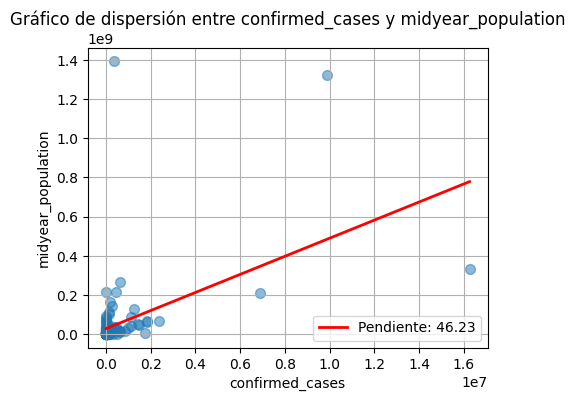

In [13]:
# Calcular la correlación de Pearson
pearson_corr = merged_df['confirmed_cases'].corr(merged_df['midyear_population'], method='pearson')

slope, intercept = np.polyfit(merged_df['confirmed_cases'], merged_df['midyear_population'], 1)

# Crear una nueva figura y ejes en la posición especificada
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0.4, 0.4, 0.5, 0.5])  # [left, bottom, width, height]

# Graficar un gráfico de dispersión
ax.scatter(merged_df['confirmed_cases'], merged_df['midyear_population'], alpha=0.5, s=50)  # Ajustar el tamaño de los puntos
ax.set_title('Gráfico de dispersión entre confirmed_cases y midyear_population')
ax.set_xlabel('confirmed_cases')
ax.set_ylabel('midyear_population')
ax.grid(True)

# Establecer los límites de los ejes


# Mostrar la correlación de Pearson
print("Correlación de Pearson entre confirmed_cases y midyear_population:", pearson_corr)

# Plot the regression line
x_values = np.array([merged_df['confirmed_cases'].min(), merged_df['confirmed_cases'].max()])
y_values = slope * x_values + intercept
ax.plot(x_values, y_values, color='red', linewidth=2, label=f'Pendiente: {slope:.2f}')

plt.legend()
plt.show()

In [14]:
merged_df = pd.merge(casos_totales_id,df1, on='geo_id')
merged_df

,geo_id,confirmed_cases,midyear_population
0,AE,184949,9992083
1,AF,49273,36643815
2,AG,148,42972878
3,AL,48530,3074579
4,AM,148682,3021324
...,...,...,...
132,VC,98,101390
133,VE,107177,32442058
134,VI,1807,37381
135,WF,3,15854


### Parte 3

Muertes diarias y Contagios Diarios. 

In [15]:


# Consulta SQL para sumar los casos diarios y las muertes diarias por fecha
query = """
    SELECT
        date,
        SUM(daily_confirmed_cases) AS total_daily_cases,
        SUM(daily_deaths) AS total_daily_deaths
    FROM
        bigquery-public-data.covid19_ecdc_eu.covid_19_geographic_distribution_worldwide
    GROUP BY
        date
    ORDER BY
        date ASC
"""

# Ejecutar la consulta
query_job = client.query(query)

# Convertir los resultados a un DataFrame de pandas
df_deathand= query_job.to_dataframe()

# Mostrar el DataFrame
df_deathand



,date,total_daily_cases,total_daily_deaths
0,2019-12-31,27,0
1,2020-01-01,0,0
2,2020-01-02,0,0
3,2020-01-03,17,0
4,2020-01-04,0,0
...,...,...,...
345,2020-12-10,676114,12376
346,2020-12-11,693352,12327
347,2020-12-12,657140,12355
348,2020-12-13,626421,10254


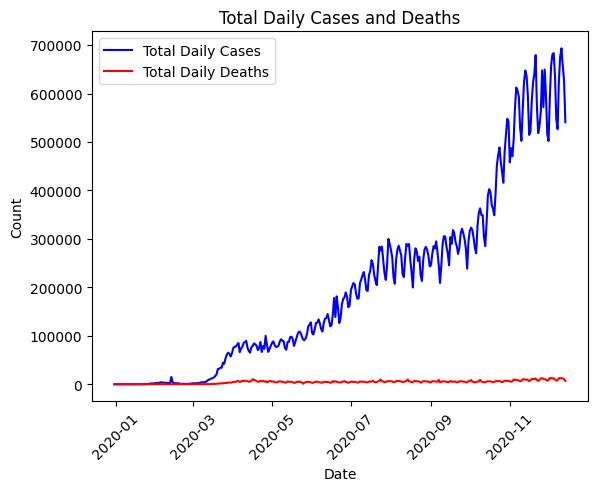

In [16]:


# Crear una figura y ejes
fig, ax = plt.subplots()

# Graficar los casos diarios
ax.plot(df_deathand['date'], df_deathand['total_daily_cases'], label='Total Daily Cases', color='blue')

# Graficar las muertes diarias
ax.plot(df_deathand['date'], df_deathand['total_daily_deaths'], label='Total Daily Deaths', color='red')

# Etiquetas y título
ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.set_title('Total Daily Cases and Deaths')

# Leyenda
ax.legend()

# Rotar las etiquetas del eje x para mayor claridad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()


### Parte 4

Tasa de mortalidad segun paises. 




In [17]:
query_top_10_countries = """
SELECT
    countries_and_territories,
    MAX(confirmed_cases) AS max_confirmed_cases,
    MAX(deaths) AS max_deaths
FROM
    bigquery-public-data.covid19_ecdc_eu.covid_19_geographic_distribution_worldwide
GROUP BY
    countries_and_territories
ORDER BY
    max_confirmed_cases DESC
LIMIT
    10;
"""

# Ejecuta la consulta para obtener los 10 países con más casos confirmados
query_job_top_10 = client.query(query_top_10_countries)

# Obtén los resultados de los 10 países como un DataFrame
df_top_10_countries = query_job_top_10.to_dataframe()

# Define la consulta SQL para obtener la suma de los casos de los países restantes
query_sum_remaining_countries = """
SELECT
    'Others' AS countries_and_territories,
    SUM(confirmed_cases) AS max_confirmed_cases,
    SUM(deaths) AS max_deaths
FROM
    bigquery-public-data.covid19_ecdc_eu.covid_19_geographic_distribution_worldwide
WHERE
    countries_and_territories NOT IN (
        SELECT
            countries_and_territories
        FROM
            bigquery-public-data.covid19_ecdc_eu.covid_19_geographic_distribution_worldwide
        GROUP BY
            countries_and_territories
        ORDER BY
            MAX(confirmed_cases) DESC
        LIMIT
            10
    );
"""

# Ejecuta la consulta para obtener la suma de los casos de los países restantes
query_job_sum_remaining = client.query(query_sum_remaining_countries)

# Obtén los resultados de la suma de los países restantes como un DataFrame
df_sum_remaining_countries = query_job_sum_remaining.to_dataframe()

# Concatena los resultados de los 10 países con la suma de los países restantes
df_combined = pd.concat([df_top_10_countries, df_sum_remaining_countries])

# Muestra el DataFrame resultante
print(df_combined)


  countries_and_territories  max_confirmed_cases  max_deaths
0  United_States_of_America             16256754      299177
1                     India              9884100      143355
2                    Brazil              6901952      181402
3                    Russia              2653928       46941
4                    France              2376852       57911
5            United_Kingdom              1849403       64170
6                     Italy              1843712       64520
7                     Spain              1730575       47624
8                 Argentina              1498160       40766
9                  Colombia              1425774       39053
0                    Others           2127798004    66781698


In [18]:
df_combined['mortality_rate'] = df_combined['max_deaths'] / df_combined['max_confirmed_cases']

df_combined

,countries_and_territories,max_confirmed_cases,max_deaths,mortality_rate
0,United_States_of_America,16256754,299177,0.018403
1,India,9884100,143355,0.014504
2,Brazil,6901952,181402,0.026283
3,Russia,2653928,46941,0.017687
4,France,2376852,57911,0.024365
5,United_Kingdom,1849403,64170,0.034698
6,Italy,1843712,64520,0.034995
7,Spain,1730575,47624,0.027519
8,Argentina,1498160,40766,0.027211
9,Colombia,1425774,39053,0.027391


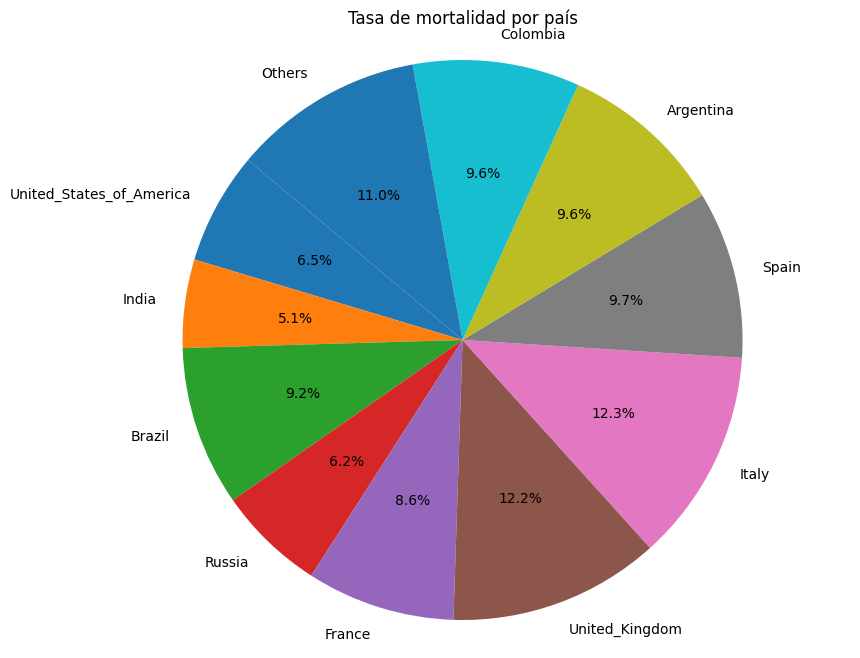

In [19]:
# Define los datos
labels = df_combined['countries_and_territories']
sizes = df_combined['mortality_rate'] * 100  # Multiplica por 100 para obtener un porcentaje

# Crea el gráfico circular
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal hace que el gráfico sea un círculo en lugar de una elipse
plt.title('Tasa de mortalidad por país')
plt.show()

### Parte 5
contagios en chile, picks y promedio:

* Recuperando la data del principio,  graficaremos los contagios diarios de Chile, encontraremos su promedio, algunos graficos de contagios diarios. 

In [20]:
df_paises

,date,countries_and_territories,confirmed_cases
0,2019-12-31,Cases_on_an_international_conveyance_Japan,0
1,2019-12-31,Afghanistan,0
2,2019-12-31,United_Arab_Emirates,0
3,2019-12-31,Armenia,0
4,2019-12-31,Australia,0
...,...,...,...
61895,2020-02-17,Taiwan,20
61896,2020-03-21,Taiwan,135
61897,2020-04-12,Taiwan,385
61898,2020-05-12,Taiwan,440


In [ ]:
class PreprocesadorDatos:
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def obtener_datos_pais(self, pais):
        # Filtrar el DataFrame para el país especificado
        df_pais = self.dataframe.loc[self.dataframe['countries_and_territories'] == pais]

        # Seleccionar las columnas 'date' y 'daily_confirmed_cases'
        df_pais_date_cases = df_pais[['date', 'daily_confirmed_cases']]

        # Ordenar los datos por fecha
        df_pais_date_cases.sort_values(by='date', inplace=True)
        

        return df_pais_date_cases
    
    def obtener_max_daily_cases(self, pais):
        # Filtrar el DataFrame para el país especificado
        df_pais = self.dataframe.loc[self.dataframe['countries_and_territories'] == pais]

        # Encontrar el valor máximo de los daily cases para el país
        max_daily_cases = df_pais['daily_confirmed_cases'].max()

        return max_daily_cases


preprocesador = PreprocesadorDatos(df)


# Obtener los datos para Chile
df_chile_date_cases = preprocesador.obtener_datos_pais('Chile')
print("\nDatos para Chile:")
print(df_chile_date_cases)
max_daily_cases_chile = preprocesador.obtener_max_daily_cases('Chile')
print("Máximo de daily cases para Chile:", max_daily_cases_chile)







Datos para Chile:
           date  daily_confirmed_cases
2986 2020-03-04                      1
2987 2020-03-05                      2
2988 2020-03-06                      1
2989 2020-03-07                      1
2990 2020-03-09                      5
...         ...                    ...
3053 2020-12-10                   1244
2983 2020-12-11                   1662
3043 2020-12-12                   1534
2984 2020-12-13                   1807
2985 2020-12-14                   2138

[285 rows x 2 columns]
Máximo de daily cases para Chile: 36179


C:\Users\Benja\AppData\Local\Temp\ipykernel_17312\3426520091.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pais_date_cases.sort_values(by='date', inplace=True)


In [ ]:

# Crear una lista para almacenar los índices de las filas que cumplen con la condición
indices_a_eliminar = []

# 
for indice, fila in df_chile_date_cases.iterrows():
    # Comprobar si el valor en la columna supera el valor límite
    if fila['daily_confirmed_cases'] > 6500 or fila['daily_confirmed_cases'] < 1 :
        # Agregar el índice de la fila a la lista de índices a eliminar
        indices_a_eliminar.append(indice)

# Eliminar las filas que cumplen con la condición
df_chile_date_cases_filtrado = df_chile_date_cases.drop(indices_a_eliminar)

df_chile_date_cases_filtrado 



,date,daily_confirmed_cases
2986,2020-03-04,1
2987,2020-03-05,2
2988,2020-03-06,1
2989,2020-03-07,1
2990,2020-03-09,5
...,...,...
3053,2020-12-10,1244
2983,2020-12-11,1662
3043,2020-12-12,1534
2984,2020-12-13,1807


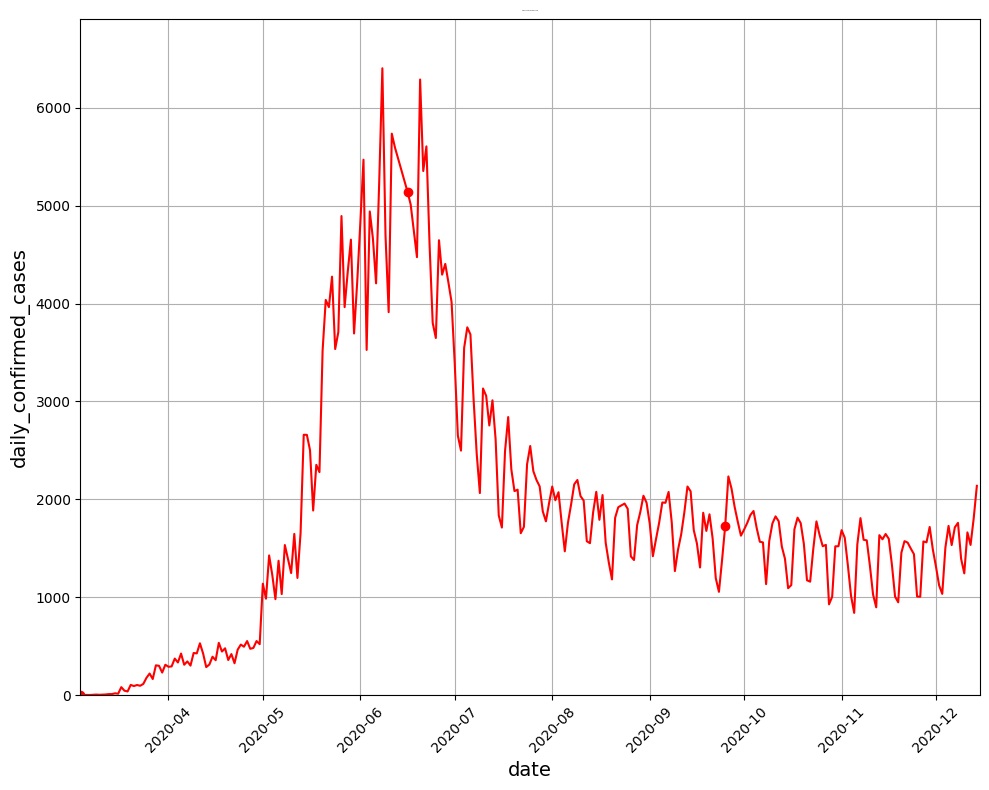

In [ ]:
class GraficadorFunciones:
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def graficar(self, columnas, country_name, color='blue'):
        plt.figure(figsize=(10, 8))  # Ajusta el tamaño de la figura
        for columna in columnas:
            # Ordena los datos por la columna de fecha antes de graficar
            datos_ordenados = self.dataframe.sort_values(by=columna[0])
            plt.plot(datos_ordenados[columna[0]], datos_ordenados[columna[1]], marker='o', linestyle='-', color=color, label=f'{columna[0]} vs {columna[1]}',  markevery=100)

        plt.title(f'Casos Diarios en {country_name}', fontsize=1)  # Ajusta el título con el nombre del país
        plt.xlabel(columnas[0][0], fontsize=14)  # Ajusta el tamaño de la fuente del eje x
        plt.ylabel(columnas[0][1], fontsize=14)  # Ajusta el tamaño de la fuente del eje y
        plt.xticks(rotation=45, fontsize=10)  # Ajusta el tamaño de la fuente de los ticks del eje x y rota las fechas
        plt.yticks(fontsize=10)
        plt.grid(True)  # Habilita la cuadrícula
        
        # Limites del eje x e y para agrandar el gráfico de USA
        plt.xlim(datos_ordenados[columnas[0][0]].min(), datos_ordenados[columnas[0][0]].max() + pd.DateOffset(days=1))
        plt.ylim(0, datos_ordenados[columnas[0][1]].max() + 500)  # Ajusta el límite superior del eje y
        
        plt.tight_layout()  # Ajusta automáticamente los márgenes
        plt.show()

# Usando la clase
graficadorchile = GraficadorFunciones(df_chile_date_cases_filtrado)
columnas = [('date', 'daily_confirmed_cases')]
color = 'red'
graficadorchile.graficar(columnas, 'Chile', color)


Podemos preguntar cual fue el dia de mas contagio, cual fue el promedio, la varianza y su desvacion estandar.  



In [ ]:
class EstadisticasContagios:
    def __init__(self, dataframe, columna_fecha, columna_contagios):
        self.dataframe = dataframe
        self.columna_fecha = columna_fecha
        self.columna_contagios = columna_contagios

    def dia_mas_contagios(self):
        maximo_contagios = self.dataframe[self.columna_contagios].max()
        dia_mas_contagios = self.dataframe[self.dataframe[self.columna_contagios] == maximo_contagios][self.columna_fecha].values[0]
        return dia_mas_contagios

    def promedio_contagios(self):
        promedio = self.dataframe[self.columna_contagios].mean()
        return promedio

    def varianza_contagios(self):
        varianza = self.dataframe[self.columna_contagios].var()
        return varianza

    def desviacion_estandar_contagios(self):
        desviacion_estandar = self.dataframe[self.columna_contagios].std()
        return desviacion_estandar




# Instancia de la clase EstadisticasContagios
estadisticas = EstadisticasContagios(df_chile_date_cases_filtrado, 'date', 'daily_confirmed_cases')

# Calcular y mostrar el día con más contagios
print("Día con más contagios:", estadisticas.dia_mas_contagios())

# Calcular y mostrar el promedio de contagios
print("Promedio de contagios:", estadisticas.promedio_contagios())

# Calcular y mostrar la varianza de contagios
print("Varianza de contagios:", estadisticas.varianza_contagios())

# Calcular y mostrar la desviación estándar de contagios
print("Desviación estándar de contagios:", estadisticas.desviacion_estandar_contagios())



Día con más contagios: 2020-06-08T00:00:00.000000000
Promedio de contagios: 1834.658362989324
Varianza de contagios: 1786139.8828673107
Desviación estándar de contagios: 1336.4654439480696
